# Install and imports of Libraries

We need to update and download libraries to make sure everything is at the latest.

In [1]:
%%capture
!pip install -U lightning twitch-dl polars mlflow dagshub mlflow "pydantic<2.0.0"
!apt install rclone

## Downloading and converting video

In [4]:
import ipywidgets
from IPython.display import display
TWITCH_ID = ipywidgets.Text("1913327875", description="Twitch ID")

display(TWITCH_ID)

Text(value='1913327875', description='Twitch ID')

### Download, Converting and Saving
Run this cell

In [74]:
print("Downloading video...")
!twitch-dl download {TWITCH_ID} -q 720p60 --output {TWITCH_ID}.mp4
!rm -fr {TWITCH_ID} && mkdir {TWITCH_ID}
!ffmpeg -hwaccel cuda -i {TWITCH_ID}.mp4 -preset faster -vf fps=3 -q:v 25 {TWITCH_ID}/img%d.jpg
print(f"Compressing Frames into {TWITCH_ID}.tar.gz")
!tar -clvf {TWITCH_ID}.tar.lz4 {TWITCH_ID}
print(f"Uploading to r2")
!rclone --config rclone.conf copy {TWITCH_ID}.tar.lz4 r2:lol-highlights-eu/frames/

## Get data from drive/r2
Run cell below

In [2]:
import polars as pl

!rclone --config rclone.conf copy r2:lol-highlights-eu/highlights.tsv .
df = pl.read_csv("highlights.tsv", separator="\t", try_parse_dates=True)
# TODO: setup rclone.conf somehow.
# TODO: validate 720P
def download_and_unpack(filename: str):
  !rclone --config rclone.conf copy r2:lol-highlights-eu/frames/{filename} .
  !tar -xvlf {filename} > /dev/null
  !rm {filename}

for vid in df["vid_id"].unique():
  download_and_unpack(f"{vid}.tar.lz4")

tar: Option --check-links is not permitted in mode -x
tar: Option --check-links is not permitted in mode -x
tar: Option --check-links is not permitted in mode -x


### Labeling...
Run this cell

In [ ]:
from pathlib import Path
import polars as pl

fps = 3

highlights = df.select(
        "vid_id",
        frame=pl.int_ranges(
            pl.col("start").cast(pl.Duration).dt.seconds() * fps,
            pl.col("stop").cast(pl.Duration).dt.seconds() * fps,
        ),
        label=pl.lit(1)
    ).explode("frame")
highlights.head(1)

vid_id,frame,label
i64,i64,i32
1863051677,2148,1


In [ ]:
import numpy as np

dfs = []
for vid in df["vid_id"].unique():
  frames = len(list(Path(str(vid)).glob("*.jpg")))
  dfs.append(pl.DataFrame({
      "vid_id": [vid] * frames,
      "frame": np.arange(1, frames + 1)
      }))

labeled_df = pl.concat(dfs)
labeled_df = labeled_df.join(highlights, on=["vid_id", "frame"], how="left").fill_null(0)
labeled_df = labeled_df.with_columns(path=pl.concat_str([pl.col("vid_id").cast(pl.Utf8) + "/img", pl.col("frame").cast(pl.Utf8) + ".jpg"]))
labeled_df = labeled_df.sort("vid_id", "frame")
labeled_df.head(2)

vid_id,frame,label,path
i64,i64,i32,str
1863051677,1,0,"""1863051677/img…"
1863051677,2,0,"""1863051677/img…"


### TODOs

- Add Training Loop into Solara
- Enable Keras as alternative

## Training (Lightning)
We train a model

## Data Sources

We support two ways to classify material. The two differentiate in how they output their data. See the following two chapters.


### Video Classification

- Input: `[batch, num_frames, height, width, channels]`
- Output: `[batch, label]`

Video Classification uses a custom `VideoDataset` which inputs a `pl.DataFrame` to know labels and file-paths.


### Image Classification

- Input: `[batch, height, width, channels]`
- Output: `[batch, label]`

For now Image Classification makes use of the default `ImageFolderDataset` in PyTorch. This dataset parses the label based on "parent folder" which requires a certain structure.


```mermaid
[A] -> [B]
```




## Define Models/Datasets

Just run all.

### Models

Here we instantiate models.

## Reducing the number of non-highlights

## Run Training

**TODO** test Efficientnet which can take larger sizes.

In [3]:
from data_utils.frame_datamodule import FrameDataModule
from data_utils.frame_dataset import FrameDataset
from data_utils.rebalancing import balance_labels
from models.rnn import RNNClassifier
from models.resnet import ResNetClassifier
from models.lightning_wrapper import LightningWrapper

In [4]:
labeled_df_rebalanced = balance_labels(labeled_df)

NameError: name 'labeled_df' is not defined

In [ ]:
# import dagshub
from lightning.pytorch.loggers import MLFlowLogger
from lightning.pytorch.callbacks import ModelCheckpoint
import torchvision.transforms as F
from mlflow.pytorch import mlflow

#dagshub.init("lol_highlights", "Lundez", mlflow=True)
mlf_logger = MLFlowLogger(log_model=True)
mlflow.pytorch.autolog()

BATCH_SIZE = 128
# Define the duration of each chunk in seconds
chunk_duration_s = 30
chunk_duration_frames = 3 * chunk_duration_s
transform = F.Compose([
  F.Resize((224, 224)),
  F.ToTensor()
])
ds = FrameDataset(labeled_df_rebalanced, transform, 1)
data = FrameDataModule(ds, BATCH_SIZE, chunk_duration_frames, pin_memory=True)

model = ResNetClassifier(models.resnet50())
# model = RNNClassifier(models.resnet18())
model = LightningWrapper(model, learning_rate=1e-4)
trainer = L.Trainer(max_epochs=5, logger=mlf_logger, callbacks=[ModelCheckpoint(".")])


with mlflow.start_run():
  trainer.fit(model, datamodule=data)

2023/09/17 14:43:28 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
2023/09/17 14:43:36 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.10/dist-packages/mlflow/pytorch/_lightning_autolog.py:351: UserWarning: Autologging is known to be compatible with pytorch-lightning versions between 1.0.5 and 2.0.8 and may not succeed with packages outside this range."
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:617

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
2023/09/17 15:26:14 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/09/17 15:26:24 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.15.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.15.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/09/17 15:26:25 WARNING mlflow.utils.requirements_utils: Found torchaudio version (2.0.2+cu118) contains a local version label (+cu118). MLf

In [ ]:
from safetensors import safe_open
from safetensors.torch import save_file
save_file(model.model, "model.safetensors")
trainer.save_checkpoint("/content/drive/MyDrive/rnn_4epochs.pt")

## Testing

In [ ]:
download_and_unpack("1913327875.tar.lz4")

In [7]:
import inference
import lightning as L
from torchvision import models
from models.lightning_wrapper import LightningWrapper
from models.resnet import ResNetClassifier
from pathlib import Path

df = inference.run_inference(L.Trainer(), LightningWrapper.load_from_checkpoint(
    "resnet.ckpt", model=ResNetClassifier(models.resnet50()), learning_rate=1e-4
), Path("1913327875"))
df

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/Users/londogard/micromamba/envs/lol_highlights/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: UserWarning:

Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.



Predicting: |          | 0/? [00:00<?, ?it/s]

torch.Size([900, 2])
% highlights predicted tensor(0.)
% highlights 0.0


frame,preds,hour,minute,second,timestamp
i64,i64,i64,i64,i64,time
0,0,0,0,0,00:00:00
30,0,0,0,30,00:00:30
60,0,0,1,0,00:01:00
90,0,0,1,30,00:01:30
120,0,0,2,0,00:02:00
150,0,0,2,30,00:02:30
180,0,0,3,0,00:03:00
210,0,0,3,30,00:03:30
240,0,0,4,0,00:04:00


In [5]:
import plotly.express as px

px.line(df, x="timestamp", y="preds", line_shape="hv")

## Old Code (Fast.AI)
See code below!

In [ ]:
from fastai.vision.all import *

In [ ]:
from sklearn.model_selection import train_test_split


def chunk_splitter(total_size: int, chunk_size: int, split: int | float) -> np.array:
    _, val_idxs = train_test_split(np.arange(total_size // chunk_size), test_size=split, random_state=42) # ignoring final unsized chunk
    is_valid = np.zeros(total_size, dtype=np.int8)

    for index in val_idxs:
        index *= chunk_size
        is_valid[index:index+chunk_size] = 1

    return is_valid

In [ ]:
from torchvision.datasets import ImageFolder

# Define the duration of each chunk in seconds
chunk_duration_s = 10
chunk_duration_frames = 3 * chunk_duration_s

# Define the path to the video frames directory
frames_directory = 'labeled_data'

# Create the ImageFolder dataset
dataset = ImageFolder(root=frames_directory)
# Calculate the total number of chunks
split = chunk_splitter(len(dataset), chunk_size=chunk_duration_frames, split=.15)

In [ ]:
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                    get_items=get_image_files,
                    splitter=MaskSplitter(split.astype("bool")),
                    get_y=parent_label,
                    item_tfms=Resize(224))
dls = ImageDataLoaders.from_dblock(dblock, frames_directory, path=frames_directory)

In [ ]:
len(split)

65731

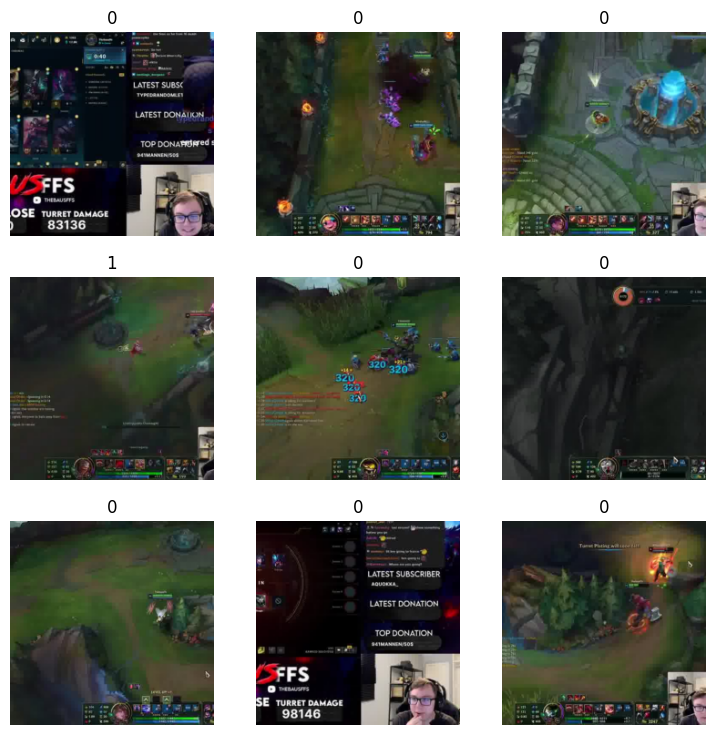

In [ ]:
dls.show_batch()

In [ ]:
learn = vision_learner(dls, resnet50, metrics=[error_rate, F1Score()])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.001737800776027143)

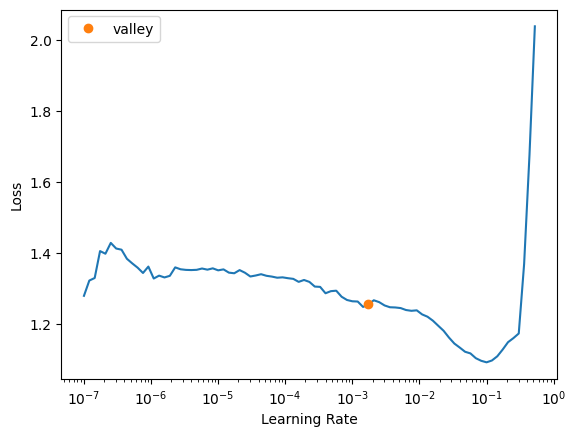

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(4, 1e-3)

epoch,train_loss,valid_loss,error_rate,f1_score,time
0,0.285462,0.262470,0.109119,0.592509,09:01


epoch,train_loss,valid_loss,error_rate,f1_score,time
0,0.183119,0.170889,0.067579,0.766047,11:05
1,0.103206,0.106959,0.039108,0.871419,11:03


In [ ]:
learn.export("/content/drive/MyDrive/datasets/fastai_resnet50.pth")

## Evaluation
And evaluating end-results